In [1]:
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats

# visualization
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
az.style.use('seaborn-colorblind')

2022-09-14 18:32:11.820953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 18:32:12.497290: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-14 18:32:17.670772: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-14 18:32:17.670897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# define grid
n_points = 20 # change to an odd number for Code 2.5 graphs to
              # match book examples in Figure 2.6
p_grid = tf.linspace(start=0., stop=1., num=n_points)

#define prior
prior = tf.ones([n_points])

# compute likelihood at each value in grid
likelihood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / tf.reduce_sum(unstd_posterior)

posterior

2022-09-14 18:32:30.547307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 18:32:30.662342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 18:32:30.662844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 18:32:30.671985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.00000000e+00, 7.98985070e-07, 4.30771506e-05, 4.09079599e-04,
       1.89388776e-03, 5.87387430e-03, 1.40429335e-02, 2.78517473e-02,
       4.78011481e-02, 7.28073865e-02, 9.98729616e-02, 1.24264337e-01,
       1.40314296e-01, 1.42834902e-01, 1.28943339e-01, 9.98729020e-02,
       6.20589107e-02, 2.64547672e-02, 4.65966808e-03, 0.00000000e+00],
      dtype=float32)>

In [3]:
likelihood/tf.reduce_sum(likelihood)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.00000000e+00, 7.98985070e-07, 4.30771506e-05, 4.09079599e-04,
       1.89388776e-03, 5.87387430e-03, 1.40429335e-02, 2.78517473e-02,
       4.78011481e-02, 7.28073865e-02, 9.98729616e-02, 1.24264337e-01,
       1.40314296e-01, 1.42834902e-01, 1.28943339e-01, 9.98729020e-02,
       6.20589107e-02, 2.64547672e-02, 4.65966808e-03, 0.00000000e+00],
      dtype=float32)>

In [4]:
def plot_cdf(grid, samples):
    _, ax = plt.subplots(figsize=(9, 4))
    ax.plot(grid, samples, "-o")
    ax.set(
        xlabel="probability of water",
        ylabel="posterior probability",
        title="20 points");

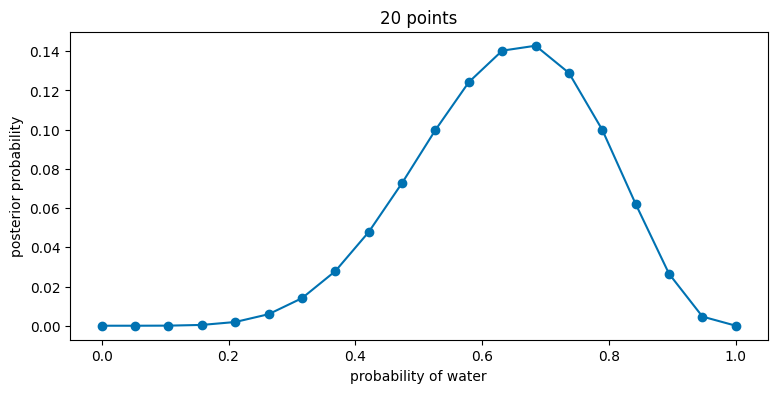

In [5]:
plot_cdf(p_grid, posterior)

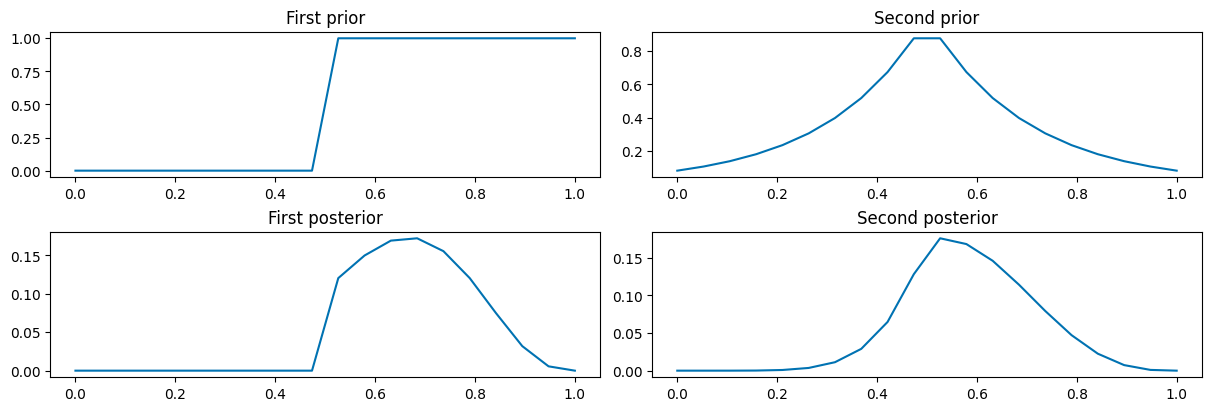

In [6]:
first_prior = tf.where(condition=p_grid < 0.5, x=0., y=1)
second_prior = tf.exp(-5 * abs(p_grid - 0.5))

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4),
                       constrained_layout=True)

axes[0, 0].plot(p_grid, first_prior)
axes[0, 0].set_title('First prior')
axes[1, 0].plot(p_grid, first_prior * likelihood/tf.math.reduce_sum(first_prior * likelihood))
axes[1, 0].set_title('First posterior')

axes[0, 1].plot(p_grid, second_prior)
axes[0, 1].set_title('Second prior')
# axes[1, 1].plot(p_grid, second_prior * likelihood/tf.math.reduce_sum(second_prior * likelihood))
axes[1, 1].plot(p_grid, second_prior * likelihood/tf.math.reduce_sum(second_prior * likelihood))
axes[1, 1].set_title('Second posterior');

In [7]:
W = 6
L = 3
dist = tfd.JointDistributionNamed({
    "water": lambda probability: tfd.Binomial(total_count=W + L,
                                              probs=probability),
    "probability": tfd.Uniform(low=0., high=1.)
})

def neg_log_prob(x):
    print(x)
    value = tfp.math.value_and_gradient(
          lambda p: -dist.log_prob(
              water=W,
              probability=tf.clip_by_value(p[-1], 0., 1.)),
          x,
    )
    print(value)
    return value

results = tfp.optimizer.bfgs_minimize(neg_log_prob, initial_position=[0.5])
assert results.converged

tf.Tensor([0.5], shape=(1,), dtype=float32)
(<tf.Tensor: shape=(), dtype=float32, numpy=1.8075066>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-6.], dtype=float32)>)
tf.Tensor([6.5], shape=(1,), dtype=float32)
(<tf.Tensor: shape=(), dtype=float32, numpy=inf>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
tf.Tensor([3.5], shape=(1,), dtype=float32)
(<tf.Tensor: shape=(), dtype=float32, numpy=inf>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
tf.Tensor([2.], shape=(1,), dtype=float32)
(<tf.Tensor: shape=(), dtype=float32, numpy=inf>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
tf.Tensor([1.25], shape=(1,), dtype=float32)
(<tf.Tensor: shape=(), dtype=float32, numpy=inf>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
tf.Tensor([0.875], shape=(1,), dtype=float32)
(<tf.Tensor: shape=(), dtype=float32, numpy=2.608695>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([

In [8]:
@tf.function
def do_sampling():
  def get_model_log_prob(probs):
    return  tfd.Binomial(total_count=W + L, probs=probs).log_prob(W)

  sampling_kernel = tfp.mcmc.RandomWalkMetropolis(get_model_log_prob)

  return tfp.mcmc.sample_chain(
      num_results=10000,
      current_state=.5,
      kernel=sampling_kernel,
      num_burnin_steps=1000,
    trace_fn=None,
  )

samples = do_sampling()

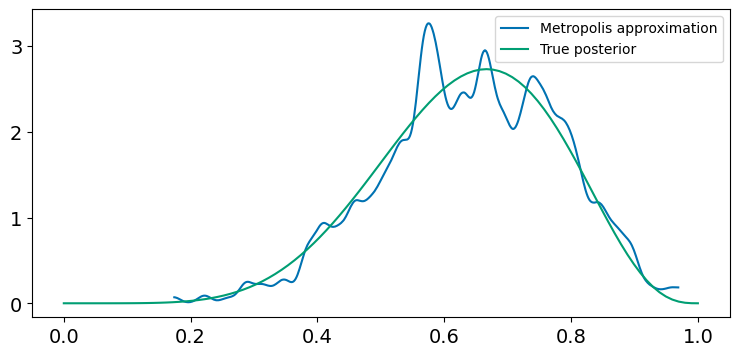

In [9]:
_, ax = plt.subplots(figsize=(9, 4))

az.plot_kde(samples.numpy(), label="Metropolis approximation", ax=ax)
x = tf.linspace(0., 1., num=100)
ax.plot(x, tfd.Beta(W + 1, L + 1).prob(x), "C1", label="True posterior")
ax.legend();